### Actinomycin D
### C62 H86 N12 O16

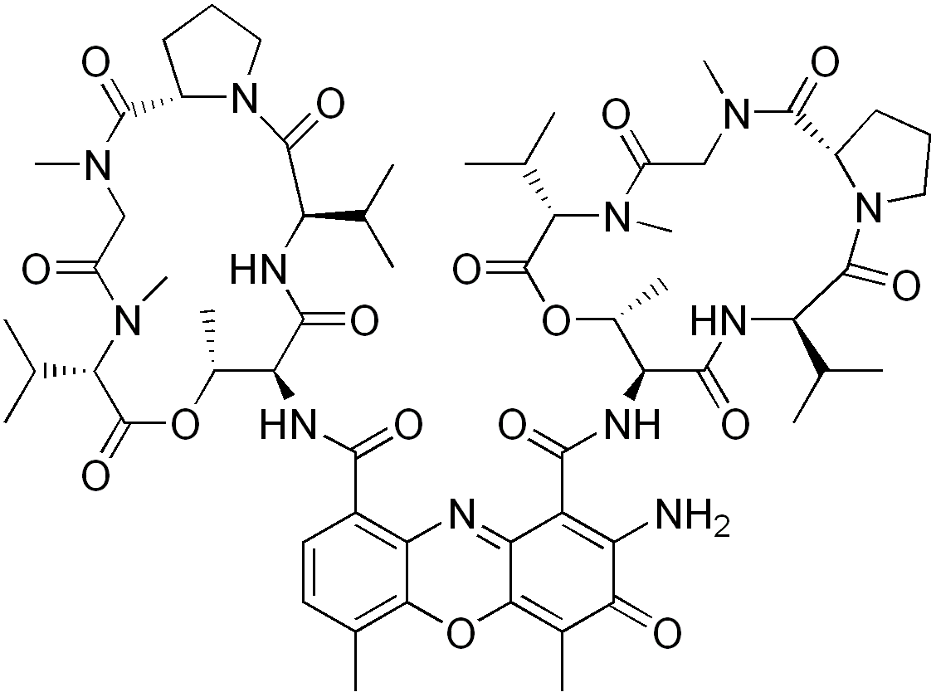

### Reading file
CIF-file - Crystallographic Information File

In [1]:
f = open("PRDCC_000001.cif","r")
lines = f.readlines()
f.close()

We need to find the boundaries of blocks that contain node information and edge information. Finding the word 'loop' helps us defind the starting point.

In [2]:
block=[]
for i,l in enumerate(lines):
    if 'loop' in l:
        block.append(i)
print (block)    

[27, 227, 418, 432]


Getting headers for node data

In [3]:
chem_comp_atom_header=[]
for i in range(block[0]+1,block[1]):
    if '_chem_comp_atom' in lines[i]:
        chem_comp_atom_header.append(lines[i].replace('_chem_comp_atom.','').replace(' \n',''))
    else:
        dataframe_nodes_start=i
        break

print(*chem_comp_atom_header, sep = "\n")

comp_id
atom_id
alt_atom_id
type_symbol
charge
pdbx_align
pdbx_aromatic_flag
pdbx_leaving_atom_flag
pdbx_stereo_config
model_Cartn_x
model_Cartn_y
model_Cartn_z
pdbx_model_Cartn_x_ideal
pdbx_model_Cartn_y_ideal
pdbx_model_Cartn_z_ideal
pdbx_component_comp_id
pdbx_residue_numbering
pdbx_component_atom_id
pdbx_polymer_type
pdbx_ref_id
pdbx_component_id
pdbx_ordinal


Getting headers for edge data

In [4]:
chem_comp_bond_header=[]
for i in range(block[1]+1,block[2]):
    if '_chem_comp_bond' in lines[i]:
        chem_comp_bond_header.append(lines[i].replace('_chem_comp_bond.','').replace(' \n',''))
    else:
        dataframe_edges_start=i
        break

print(*chem_comp_bond_header, sep = "\n")
#print(dataframe_edges_start)

comp_id
atom_id_1
atom_id_2
value_order
pdbx_aromatic_flag
pdbx_stereo_config
pdbx_ordinal


In [5]:
data=[]
for i in range (dataframe_nodes_start,block[1]-1):
    data.append(lines[i].split())

In [6]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.sql.functions import *

Creating node and edge dataframes

In [7]:
df_nodes = spark.createDataFrame(data=data, schema = chem_comp_atom_header)
df_nodes.select('atom_id','type_symbol','model_Cartn_x','model_Cartn_y','model_Cartn_z', 'pdbx_residue_numbering').show(5)

+-------+-----------+-------------+-------------+-------------+----------------------+
|atom_id|type_symbol|model_Cartn_x|model_Cartn_y|model_Cartn_z|pdbx_residue_numbering|
+-------+-----------+-------------+-------------+-------------+----------------------+
|     N1|          N|       11.239|        9.853|       11.574|                     1|
|     C1|          C|       12.334|        9.171|       10.911|                     1|
|     C2|          C|       12.770|       10.028|        9.704|                     1|
|     O1|          O|       12.014|       10.868|        9.208|                     1|
|     C3|          C|       11.959|        7.792|       10.343|                     1|
+-------+-----------+-------------+-------------+-------------+----------------------+
only showing top 5 rows



In [8]:
data=[]
for i in range (dataframe_edges_start,block[2]-1):
    data.append(lines[i].split())

In [9]:
df_edges = spark.createDataFrame(data=data, schema = chem_comp_bond_header)
df_edges.show(5)

+----------+---------+---------+-----------+------------------+------------------+------------+
|   comp_id|atom_id_1|atom_id_2|value_order|pdbx_aromatic_flag|pdbx_stereo_config|pdbx_ordinal|
+----------+---------+---------+-----------+------------------+------------------+------------+
|PRD_000001|       N1|       C1|       SING|                 N|                 N|           1|
|PRD_000001|       N1|       H1|       SING|                 N|                 N|           2|
|PRD_000001|       C1|       C2|       SING|                 N|                 N|           3|
|PRD_000001|       C1|       C3|       SING|                 N|                 N|           4|
|PRD_000001|       C1|       H2|       SING|                 N|                 N|           5|
+----------+---------+---------+-----------+------------------+------------------+------------+
only showing top 5 rows



### Filling the database

Starting to work with database: imports

In [10]:
from __future__  import print_function  # Python 2/3 compatibility

from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __, GraphTraversalSource
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection

Server data

In [11]:
graph = Graph()
remoteConn = DriverRemoteConnection(
'wss://database-final-instance-1.cr5tblj51yqv.us-east-1.neptune.amazonaws.com:8182/gremlin','g')
g = graph.traversal().withRemote(remoteConn)

In [12]:
#necessary for .next() function working
#.next() function is needed for gremlin when working with python, not needed in gremlin console
import nest_asyncio
nest_asyncio.apply()

In [ ]:
#g.V().drop().iterate() #To clear DB if needed

In [13]:
g.V().count().next()  # to validate connection, should return ‘0’, if the DB is empty

0

Adding nodes

In [14]:
df_nodes_collection = df_nodes.collect()
for row in df_nodes_collection:
    g.addV(row['type_symbol'])\
    .property('atom_id', row['atom_id'])\
    .property('pdbx_residue_numbering',row['pdbx_residue_numbering'])\
    .next()
g.V().count().next()

176

In [15]:
print(*g.V().valueMap(True).toList(), sep = "\n")

{'pdbx_residue_numbering': ['3'], 'atom_id': ['C12'], <T.id: 1>: '4ec3fe4d-b08b-cdaa-0b0e-1ed788c2e450', <T.label: 4>: 'C'}
{'pdbx_residue_numbering': ['6'], 'atom_id': ['C34'], <T.id: 1>: 'cac3fe4d-b35a-ee73-c469-7e805c557013', <T.label: 4>: 'C'}
{'pdbx_residue_numbering': ['11'], 'atom_id': ['N12'], <T.id: 1>: '7ac3fe4d-b494-cdce-b7d6-3565267ad46d', <T.label: 4>: 'N'}
{'pdbx_residue_numbering': ['4'], 'atom_id': ['H25'], <T.id: 1>: 'dcc3fe4d-b581-8c29-7270-a2dee70c6fb4', <T.label: 4>: 'H'}
{'pdbx_residue_numbering': ['8'], 'atom_id': ['H57'], <T.id: 1>: '7ec3fe4d-b6a3-515e-c6dc-e68b0e67e749', <T.label: 4>: 'H'}
{'pdbx_residue_numbering': ['5'], 'atom_id': ['C21'], <T.id: 1>: '36c3fe4d-b242-52c1-8637-ffa8bbe77171', <T.label: 4>: 'C'}
{'pdbx_residue_numbering': ['7'], 'atom_id': ['C43'], <T.id: 1>: '9cc3fe4d-b3d1-e4a9-d9b9-eef2ce850774', <T.label: 4>: 'C'}
{'pdbx_residue_numbering': ['1'], 'atom_id': ['H5'], <T.id: 1>: '2cc3fe4d-b4ea-093a-770a-0321ff989929', <T.label: 4>: 'H'}
{'pdbx_r

In [16]:
df_edges.show(3)

+----------+---------+---------+-----------+------------------+------------------+------------+
|   comp_id|atom_id_1|atom_id_2|value_order|pdbx_aromatic_flag|pdbx_stereo_config|pdbx_ordinal|
+----------+---------+---------+-----------+------------------+------------------+------------+
|PRD_000001|       N1|       C1|       SING|                 N|                 N|           1|
|PRD_000001|       N1|       H1|       SING|                 N|                 N|           2|
|PRD_000001|       C1|       C2|       SING|                 N|                 N|           3|
+----------+---------+---------+-----------+------------------+------------------+------------+
only showing top 3 rows



Adding edges

In [17]:
df_edges_collection = df_edges.collect()

for row in df_edges_collection:
    g.V(g.V().has('atom_id',row['atom_id_1']).next())\
    .addE(row['value_order'])\
    .property('pdbx_ordinal',row['pdbx_ordinal'])\
    .to(__.V(g.V().has('atom_id',row['atom_id_2']).next())).next()

In [18]:
print(*g.E().valueMap(True).toList(), sep = "\n")

{<T.id: 1>: '0cc3fe4d-d293-2a15-f15a-8683ff7fd409', <T.label: 4>: 'SING', 'pdbx_ordinal': '107'}
{<T.id: 1>: '3ac3fe4d-cb14-d23a-295f-b98b02a95cda', <T.label: 4>: 'SING', 'pdbx_ordinal': '26'}
{<T.id: 1>: '04c3fe4d-c954-51fc-2fa7-3ae6b6f23af6', <T.label: 4>: 'SING', 'pdbx_ordinal': '5'}
{<T.id: 1>: '20c3fe4d-d431-7a3d-4aba-8baf733bea30', <T.label: 4>: 'SING', 'pdbx_ordinal': '126'}
{<T.id: 1>: '28c3fe4d-d4fb-1e1b-b0b4-a9713f477134', <T.label: 4>: 'SING', 'pdbx_ordinal': '137'}
{<T.id: 1>: '9ac3fe4d-d332-8470-8ed8-8ee7cba147d4', <T.label: 4>: 'SING', 'pdbx_ordinal': '116'}
{<T.id: 1>: '0ec3fe4d-d445-4518-36f2-de47cc49a124', <T.label: 4>: 'SING', 'pdbx_ordinal': '127'}
{<T.id: 1>: '30c3fe4d-d7e4-bc82-83c9-7250feebfcba', <T.label: 4>: 'SING', 'pdbx_ordinal': '181'}
{<T.id: 1>: 'a8c3fe4d-cc25-b061-0977-6d8d9102673c', <T.label: 4>: 'SING', 'pdbx_ordinal': '42'}
{<T.id: 1>: 'e6c3fe4d-ce36-1b65-af53-2b432c9245e2', <T.label: 4>: 'SING', 'pdbx_ordinal': '64'}
{<T.id: 1>: '92c3fe4d-cb90-d660-306

### Visualization

In [19]:
%%graph_notebook_config

{
  "host": "database-final-instance-1.cr5tblj51yqv.us-east-1.neptune.amazonaws.com",
  "port": 8182,
  "proxy_host": "",
  "proxy_port": 8182,
  "auth_mode": "DEFAULT",
  "load_from_s3_arn": "",
  "ssl": true,
  "ssl_verify": true,
  "aws_region": "us-east-1",
  "sparql": {
    "path": ""
  },
  "gremlin": {
    "traversal_source": "g",
    "username": "",
    "password": "",
    "message_serializer": "graphsonv3"
  },
  "neo4j": {
    "username": "neo4j",
    "password": "password",
    "auth": true,
    "database": null
  }
}

set notebook config to:
{
  "host": "database-final-instance-1.cr5tblj51yqv.us-east-1.neptune.amazonaws.com",
  "port": 8182,
  "proxy_host": "",
  "proxy_port": 8182,
  "auth_mode": "DEFAULT",
  "load_from_s3_arn": "",
  "ssl": true,
  "ssl_verify": true,
  "aws_region": "us-east-1",
  "sparql": {
    "path": ""
  },
  "gremlin": {
    "traversal_source": "g",
    "username": "",
    "password": "",
    "message_serializer": "graphsonv3"
  },
  "neo4j": {
    "username": "neo4j",
    "password": "password",
    "auth": true,
    "database": null
  }
}


here all circles (or something else) can be changed if necessary.
For example, nodes with the label 'person' can be replaced by person picture.
We need to print %%graph_notebook_vis_options and specify the options below. If we print %graph_notebook_vis_options. we can look through the options 

In [20]:
%graph_notebook_vis_options

{
  "nodes": {
    "borderWidthSelected": 0,
    "borderWidth": 0,
    "color": {
      "background": "rgba(210, 229, 255, 1)",
      "border": "transparent",
      "highlight": {
        "background": "rgba(9, 104, 178, 1)",
        "border": "rgba(8, 62, 100, 1)"
      }
    },
    "shadow": {
      "enabled": false
    },
    "shape": "circle",
    "widthConstraint": {
      "minimum": 70,
      "maximum": 70
    },
    "font": {
      "face": "courier new",
      "color": "black",
      "size": 12
    }
  },
  "edges": {
    "color": {
      "inherit": false
    },
    "smooth": {
      "enabled": true,
      "type": "straightCross"
    },
    "arrows": {
      "to": {
        "enabled": true,
        "type": "arrow"
      }
    },
    "font": {
      "face": "courier new"
    }
  },
  "interaction": {
    "hover": true,
    "hoverConnectedEdges": true,
    "selectConnectedEdges": false
  },
  "physics": {
    "simulationDuration": 1500,
    "disablePhysicsAfterInitialSimulation": 

In [21]:
%%gremlin
g.V().out().path()

Here: C - blue, N - red, O - green, H - yellow. It is visible using zoom. zoomed graph is shown below.

In [22]:
%%gremlin
g.V().out().path()

In [23]:
node_labels = {"atom_id":"pdbx_residue_numbering"}
edge_labels = {"pdbx_ordinal"}

In [24]:
%%gremlin -d $node_labels -de $edge_labels
g.V().outE().inV().path().by(elementMap())

the same graph, zoomed

In [25]:
%%gremlin -d $node_labels -de $edge_labels
g.V().outE().inV().path().by(elementMap())

In [26]:
%%gremlin 
g.V().hasLabel('C','N').out().hasLabel('C','N').path()

In [27]:
%%gremlin 
g.V().hasLabel('N').out('DOUB').path().by('atom_id')

In [28]:
%%gremlin
g.V().has('atom_id','N7').outE().inV().path()

### Aggregations, path finder

In [29]:
%%gremlin 
g.V().has('atom_id','N7').out().count()

In [30]:
%%gremlin 
g.V().hasLabel('N').out('DOUB').count()

In [31]:
%%gremlin 
g.V().has('atom_id','N9').until(has('atom_id','C62')).
               repeat(both()).path().by('atom_id').next()

In [32]:
%%gremlin 
g.V().has('atom_id','C41').repeat(both()).times(3).path().by('atom_id').next()